## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [1]:
#install libraries
#!pip install scattertext
#!pip install wordcloud
#!pip install textblob

In [43]:
# pandas and numpy
import pandas as pd
import numpy as np

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
import textblob
from textblob import TextBlob

# wordcloud
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# countvectorizer, tfidfvectorizer, LDA, LB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
#!pip install --upgrade pandas
#!pip install --upgrade bottleneck
#!pip install --upgrade stack_data

In [4]:
# load data 
# ----------
congress_tweets = pd.read_csv("../../data/116th Congressional Tweets and Demographics.csv")
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
congress_tweets = congress_tweets.sample(n=10000, replace = False, random_state = 10)
congress_tweets.head()

tweet_id      screen_name                   datetime  \
36257   1.276160e+18         RepDavid  2020-06-25T10:22:13-04:00   
548996  1.082280e+18   RepSeanMaloney  2019-01-07T09:33:39-05:00   
652347  1.322270e+18   RepSteveChabot  2020-10-30T16:24:14-04:00   
267614  1.103730e+18     SenatorRisch  2019-03-07T13:33:23-05:00   
344386  1.097350e+18  RepThomasMassie  2019-02-17T23:35:06-05:00   

                                                     text  \
36257   Before adopting Olivia, we spent a great amoun...   
548996  Are we supposed to take Trump seriously or lit...   
652347  Thank you to Lieutenant Mike Tarr and Fire Chi...   
267614  Made remarks to @AmFreeSyria sharing my concer...   
344386  @jeroneanderson @MontcoLP @LelandShow @realDon...   

              name_wikipedia position joined_congress_date   birthday gender  \
36257       David Schweikert      Rep             3-Jan-13   3/3/1962      M   
548996  Sean Patrick Maloney      Rep             3-Jan-13  7/30/1966      M   
652347          Steve Chabot      Rep             3-Jan-11  1/22/1953      M   
267614             Jim Risch      Sen             3-Jan-09   5/3/1943      M   
344386         Thomas Massie      Rep            13-Nov-12  1/13/1971      M   

       state district_number       party trump_2016_state_share  \
36257     AZ               6  Republican              1,252,401   
548996    NY              18    Democrat              2,819,533   
652347    OH               1  Republican              2,841,005   
267614    ID          Senate  Republican                409,055   
344386    KY               4  Republican              1,202,971   

       clinton_2016_state_share obama_2012_state_share romney_2012_state_share  
36257                 1,161,167              1,025,232               1,233,654  
548996                4,556,118              4,485,741               2,490,431  
652347                2,394,164              2,827,709               2,661,437  
267614                  189,765                212,787                 420,911  
344386                  628,854                679,370               1,087,190

## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [5]:
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    nlp.Defaults.stop_words |= {"RT", "QT","amp", "\n", "\n\n", "\n\n\n", "\n\n\n\n", "rt", "qt"}
    
    punc = set(punctuation)
    
    #convert to lowercase
    #text = text.lower()
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    spacy_words = [token.text for token in doc]
    
    spacy_words = [word for word in spacy_words if not (word.startswith('http'))]

    # Lemmatize tokens
    lemmatized_tokens = [token.lemma_ for token in doc]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
        
    return no_punc

In [6]:
#applying rem_punc_stop to dataset
congress_tweets['tokens'] = congress_tweets['text'].map(lambda x: rem_punc_stop(x))

# collapse tokens in a string using join method since output of last step is a list
congress_tweets['tokens'] = congress_tweets['tokens'].map(lambda text: ' '.join(text))

# view
congress_tweets['tokens']


36257     Before adopting Olivia spent great time learni...
548996    Are supposed Trump seriously literally steel b...
652347    Thank Lieutenant Mike Tarr Fire Chief Ott Hube...
267614    Made remarks AmFreeSyria sharing concern devas...
344386    jeroneanderson MontcoLP LelandShow realDonaldT...
                                ...                        
337933    Kansans aware continued winter weather weekend...
344441    SenateMajLdr McConnell Comments Kentucky Flooding
411565    MichelleBrane We said beginning administration...
789238    More proof partisan impeachment inquisition ba...
294640    ReadyIllinois What social distancing These sim...
Name: tokens, Length: 10000, dtype: object

In [37]:
# making independents into dems
congress_tweets['party'] = np.where(congress_tweets['party'] == 'Independent', 'Democrat', congress_tweets['party'])


## PART 2: Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1

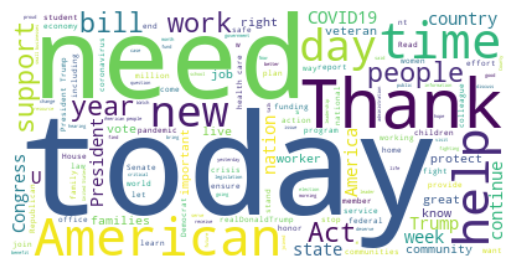

In [7]:
# Wordcloud
# apply function to text object
text2 = ' '.join(congress_tweets['tokens'])

# create WordCloud visualization using the "text" object 
wordcloud = WordCloud(background_color = "white",  # set background color to white
                      random_state=41              # set random state to ensure same word cloud each time
                      ).generate(text2)             # change the background color


# plot 
plt.imshow(wordcloud,                  # specify wordcloud
           interpolation = 'bilinear') # specifies how the words are displayed
plt.axis('off')                        # turn off axes
plt.show()    

### EDA 2

In [8]:
# topic modelling

# first, let's define a function to print the top words that we'll use in our model
# --------

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [9]:
# Latent Dirichlet Allocation (LDA)
# ---------------------------------------

# pre-processing
# --------
# create a new data object called X
X = congress_tweets['tokens']

# initialize tf-idf function and set parameters
tf = TfidfVectorizer(tokenizer = rem_punc_stop,  # specify our function for remove punc and stop words
                     token_pattern = None)       # specify "None" to remove warning. Is this necessary?

# apply tf-idf vectorizer to our data (X)
tfidf_matrix =  tf.fit_transform(X)

# modify the output to be a dense matrix
dense_matrix = tfidf_matrix.todense()

# intitialize LDA model and 
# --------
# initialize LDA and set model parameters
lda = LatentDirichletAllocation(n_components=5, # specify the number of components
                                max_iter=20,    # specify the number of iterations 
                                random_state=0) # set a seed for reproducibility

# fit LDA model to our dense matrix
lda = lda.fit(np.asarray(dense_matrix))

# post-processing
# --------
# get feature names from our tf-idf vector
tf_feature_names = tf.get_feature_names_out()

# print top words 
print_top_words(lda,               # specify model
                tf_feature_names,  # specify feature names vector
                20)                # specify how many words we want to see
 

# now transform our data using the lda model and create a dataframe
topic_dist = lda.transform(tfidf_matrix)
topic_dist_df = pd.DataFrame(topic_dist).reset_index(drop = True)

# view the corresponding tf-idf dataframe with tf-idf values
topic_dist_df


Topic #0:
nurses üèΩ evil totally huawei baseless cohen robocalls nice rapids repdougcollins ordered nationaldoctorsday alarm mention cedar parade judiciarygop exonerate nd

Topic #1:
911 amy coney reauthorization cruz ‚úî renew911vcf ted radio visitors petition venezuelans babies smoke discharge equalpay ripping endinfanticide repnewhouse compensation

Topic #2:
de el la en y para god que independence los disparities king del por happy climatecrisis su martin bless enjoy

Topic #3:
üëè schiff ambassador birthday whistleblower dcstatehood quid represented academies newsletter quo photo adam happy art maine hunter dday army normandy

Topic #4:
today    people president act trump need health covid19 house help work american time bill americans new support day congress



0         1         2         3         4
0     0.031717  0.031508  0.031502  0.031505  0.873768
1     0.049005  0.048905  0.228502  0.049013  0.624575
2     0.049483  0.049484  0.049485  0.444477  0.407071
3     0.249390  0.034635  0.034630  0.034631  0.646713
4     0.054312  0.054307  0.054295  0.054299  0.782786
...        ...       ...       ...       ...       ...
9995  0.034176  0.034210  0.034383  0.034237  0.862995
9996  0.062158  0.062158  0.062157  0.062157  0.751370
9997  0.032729  0.032723  0.032717  0.032742  0.869088
9998  0.224445  0.039146  0.036118  0.037760  0.662531
9999  0.046146  0.046146  0.046145  0.317435  0.544128

[10000 rows x 5 columns]

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

In [10]:
#Sentiment Analysis

# polarity
congress_tweets['polarity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)

# subjectivity
congress_tweets['subjectivity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

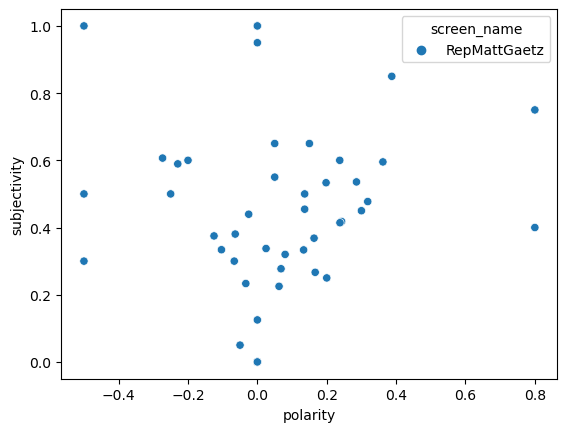

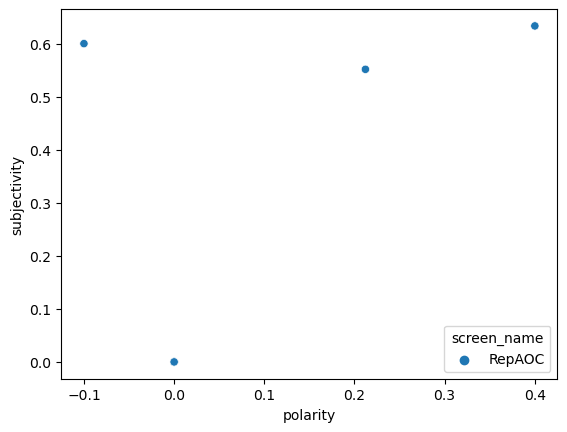

In [11]:
# Gaetz vs AOC

tweets_gaetz = congress_tweets[(congress_tweets['screen_name']=='RepMattGaetz')]
tweets_AOC = congress_tweets[(congress_tweets['screen_name'] == 'RepAOC')]

sns.scatterplot(tweets_gaetz, x="polarity", y="subjectivity", hue = 'screen_name')
plt.show()

sns.scatterplot(tweets_AOC, x="polarity", y="subjectivity", hue = 'screen_name')
plt.show()

#sns.displot(tweets_subset, x="subjectivity", hue = "screen_name", col = "screen_name")
#plt.show()

Looking at Rep. Matt Gaetz's tweets compared to Rep. Alexandria Ocasio Cortez's tweets, I was actually surprised that AOC's sampled tweets vary as much as they do in terms of polarity and subjectivity. However, Matt Gaetz's tweets have even wider polarity and subjectivity, which ultimately makes sense given extremely conservative talking points at present. What is most interesting about Gaetz is that along the 0 polarity score, he has a range of tweets varying from 0-1 on the subjectivity scale.

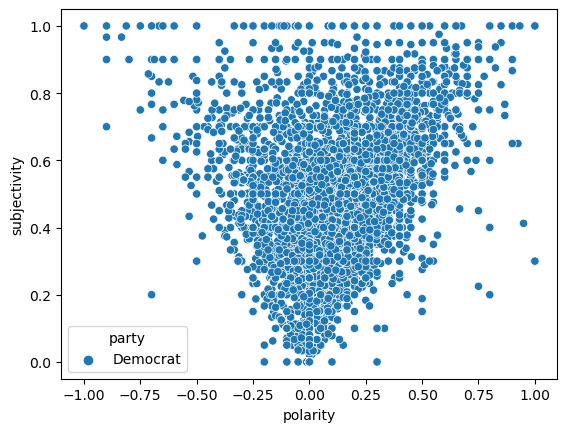

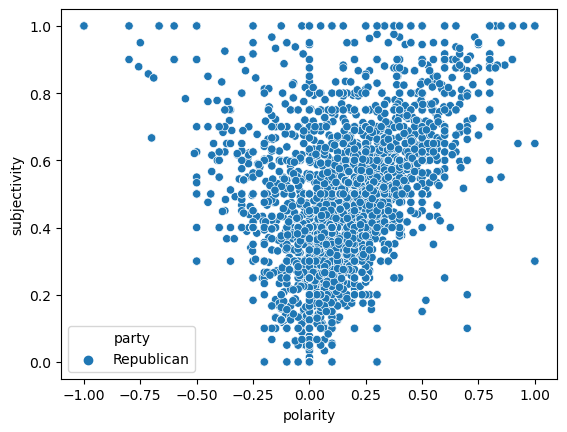

In [38]:
# Dems vs Republicans

tweets_dem = congress_tweets[(congress_tweets['party']=='Democrat')]
tweets_repub = congress_tweets[(congress_tweets['party'] == 'Republican')]

#Democrat Tweets
sns.scatterplot(tweets_dem, x="polarity", y="subjectivity", hue="party")
plt.show()

#republican tweets 
sns.scatterplot(tweets_repub, x="polarity", y="subjectivity", hue="party")
plt.show()

Here, we see that the general shape of both graphs is similar, but republican tweets tend to be on the positive side of the polarity score. Democrats see a slight concentraiton on the positive side of the polarity score as well, but have more density of points on the negative side. There is a similar range of subjectivity for both parties.

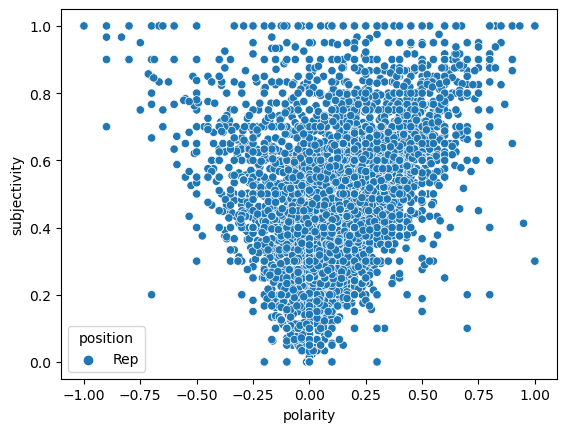

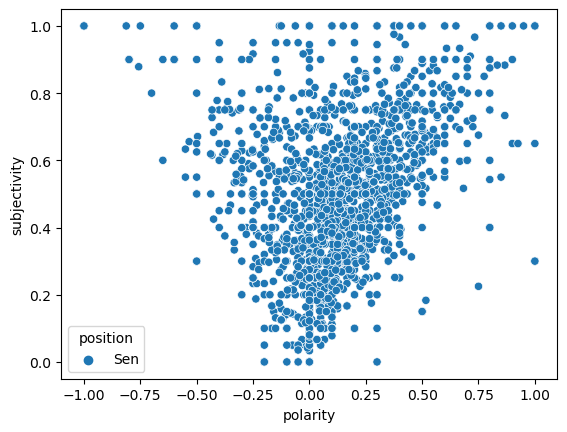

In [13]:
# House vs Senate

tweets_rep = congress_tweets[(congress_tweets['position'] == 'Rep')]
tweets_sen = congress_tweets[(congress_tweets['position'] == 'Sen')]

#House Tweets
sns.scatterplot(tweets_rep, x="polarity", y="subjectivity", hue="position")
plt.show()

#Senate Tweets
sns.scatterplot(tweets_sen, x="polarity", y="subjectivity", hue="position")
plt.show()


While this is harder to compare due to the differences in number of elected officials, Senate tweets appear to be less subjective and less polarized, with a greater relative concentration of points toward the lower end of both the subjectivity and polarity scales. This aligns with our hypothesis that Senators would have more moderate tweets. 

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

In [14]:
...

Ellipsis

### Engineered Text Features

In [16]:
# Engineered Features

# select engineered text features
engineered_features = congress_tweets[['polarity', 
                            'subjectivity']].reset_index(drop = True)

# Topic Model + Engineered Features
# --------
# combine results from our topic model + engineered features
engineered_features_with_topics = topic_dist_df.join(engineered_features.reset_index(drop = True))
engineered_features_with_topics

0         1         2         3         4  polarity  subjectivity
0     0.031717  0.031508  0.031502  0.031505  0.873768  0.283333      0.491667
1     0.049005  0.048905  0.228502  0.049013  0.624575 -0.333333      0.666667
2     0.049483  0.049484  0.049485  0.444477  0.407071  0.500000      0.500000
3     0.249390  0.034635  0.034630  0.034631  0.646713 -0.437500      0.500000
4     0.054312  0.054307  0.054295  0.054299  0.782786  0.000000      0.000000
...        ...       ...       ...       ...       ...       ...           ...
9995  0.034176  0.034210  0.034383  0.034237  0.862995 -0.083333      0.596667
9996  0.062158  0.062158  0.062157  0.062157  0.751370  0.000000      0.000000
9997  0.032729  0.032723  0.032717  0.032742  0.869088 -0.533333      0.775000
9998  0.224445  0.039146  0.036118  0.037760  0.662531 -0.066667      0.594444
9999  0.046146  0.046146  0.046145  0.317435  0.544128 -0.088889      0.274603

[10000 rows x 7 columns]

### Bag-of-words or Tf-idf

In [20]:
# Frequency Based featurization
tf = TfidfVectorizer(tokenizer = rem_punc_stop)
tfidf_matrix =  tf.fit_transform(congress_tweets['text'])
tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns = tf.get_feature_names_out()).reset_index(drop=True)
tfidf_df

/Users/jacquelinebrown/anaconda3/envs/CSS/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


\n\n   \n\n           \n\n¬†   \n   \n \n  \n \n   \n    \n     \n   \n  \
0       0.0            0.0     0.0  0.0    0.0     0.0   0.0    0.0      0.0   
1       0.0            0.0     0.0  0.0    0.0     0.0   0.0    0.0      0.0   
2       0.0            0.0     0.0  0.0    0.0     0.0   0.0    0.0      0.0   
3       0.0            0.0     0.0  0.0    0.0     0.0   0.0    0.0      0.0   
4       0.0            0.0     0.0  0.0    0.0     0.0   0.0    0.0      0.0   
...     ...            ...     ...  ...    ...     ...   ...    ...      ...   
9995    0.0            0.0     0.0  0.0    0.0     0.0   0.0    0.0      0.0   
9996    0.0            0.0     0.0  0.0    0.0     0.0   0.0    0.0      0.0   
9997    0.0            0.0     0.0  0.0    0.0     0.0   0.0    0.0      0.0   
9998    0.0            0.0     0.0  0.0    0.0     0.0   0.0    0.0      0.0   
9999    0.0            0.0     0.0  0.0    0.0     0.0   0.0    0.0      0.0   

      \n        ...    üß°    üß¶    üß®    üß¥    üßµ    üßº   ü©∫a  ü©∫amp  ü©∫health  ü©∫the  
0          0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0      0.0   0.0  
1          0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0      0.0   0.0  
2          0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0      0.0   0.0  
3          0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0      0.0   0.0  
4          0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0      0.0   0.0  
...        ...  ...  ...  ...  ...  ...  ...  ...  ...   ...      ...   ...  
9995       0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0      0.0   0.0  
9996       0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0      0.0   0.0  
9997       0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0      0.0   0.0  
9998       0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0      0.0   0.0  
9999       0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0      0.0   0.0  

[10000 rows x 27330 columns]

### Word Embedding

In [ ]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 

#model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary = True) 

In [21]:
# Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
#def document_vector(word2vec_model, doc):
    #doc = [word for word in doc if word in model.vocab]
    #return np.mean(model[doc], axis=0)

In [33]:
# CBOW word2vec
model = gensim.models.Word2Vec(congress_tweets['text'],    # specify data - sentences
                               vector_size=100,   # set embedding size at 100
                               window=5,          # max distance between current and predicted word
                               min_count=5,       # ignores words with freq fewer than this threshold
                               sg=0,              # specify Continuous Bag of Words Algorithim
                               alpha=0.025,       # learning rate
                               epochs = 5,        # iterations
                               seed = 1,          # set random seed (same as random_state in sklearn )
                               batch_words=10000, # sample size 
                               workers = 1)       # set cores to 1 to ensure this embeddings are fully reproducible

In [34]:
# create function to do find mean vector for every token and document in our corpus
# ----------
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.wv.index_to_key]
    return np.mean(word2vec_model.wv.__getitem__(doc), axis=0)

In [35]:
# embedding based featurization


# create an array for the size of the corpus
# ----------
empty_list_embeddings_means = []
for word in congress_tweets['text']: # append the vector for each document
    empty_list_embeddings_means.append(document_vector(model, word))
    
doc_average_embeddings = np.array(empty_list_embeddings_means) # list to array

# print averages
doc_average_embeddings

array([[ 0.21738963,  0.10898109,  0.5507684 , ...,  0.11473294,
        -0.15649663,  0.08164554],
       [ 0.301121  ,  0.0685178 ,  0.6137008 , ...,  0.17640817,
        -0.1741539 ,  0.32023284],
       [ 0.19608426,  0.06451405,  0.41330636, ...,  0.1551937 ,
        -0.15981671,  0.1830376 ],
       ...,
       [ 0.26288688,  0.09100804,  0.66586405, ...,  0.15929727,
        -0.18403502,  0.11598454],
       [ 0.29988042,  0.12460278,  0.67237276, ...,  0.0811222 ,
        -0.22573164,  0.15782686],
       [ 0.21597713,  0.10199668,  0.35412365, ...,  0.04770524,
        -0.09417149,  0.11623981]], dtype=float32)

In [36]:
doc_average_embeddings.shape

(10000, 100)

## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [41]:
# six models ([engineered features, frequency-based, embedding] * [democrat/republican, senator/representative])
dataframes = [engineered_features, tfidf_df, doc_average_embeddings]
featurization_technique = ['Engineered Text Features',
                           'Tf-idf Features',
                           'Word2vec Features']

# Y = [Dem/rep, sen/rep]
lb_style = LabelBinarizer()
y_party = congress_tweets['party_binary'] = lb_style.fit_transform(congress_tweets["party"])
y_position = congress_tweets['position_binary'] = lb_style.fit_transform(congress_tweets["position"])

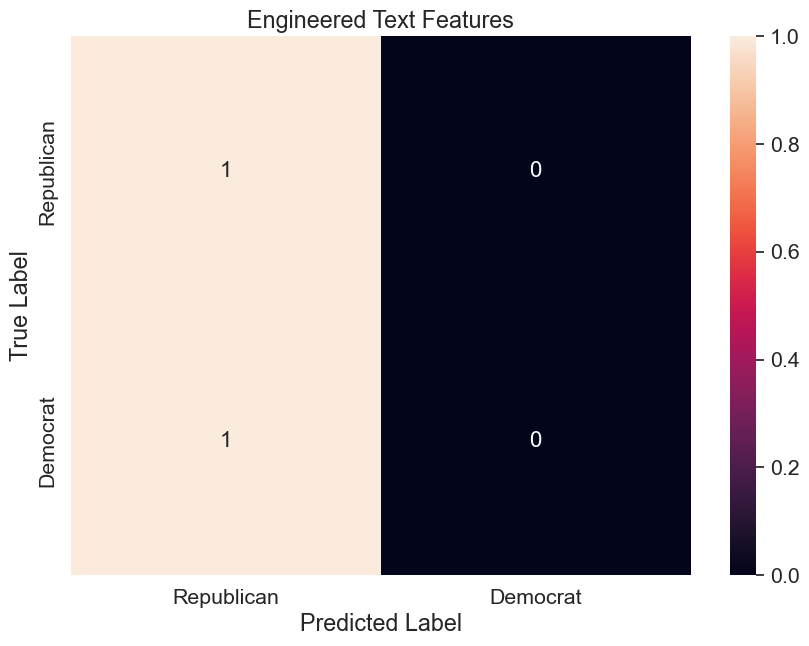

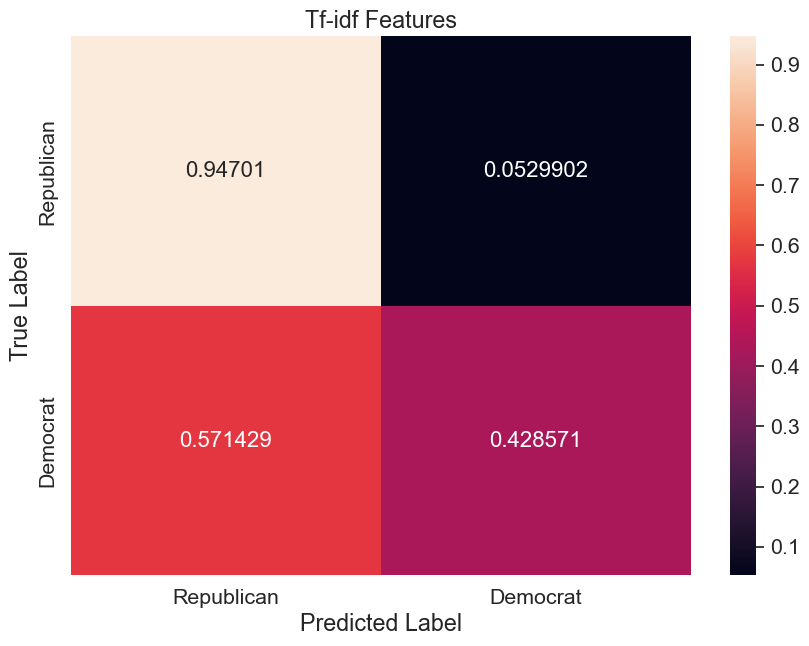

/Users/jacquelinebrown/anaconda3/envs/CSS/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


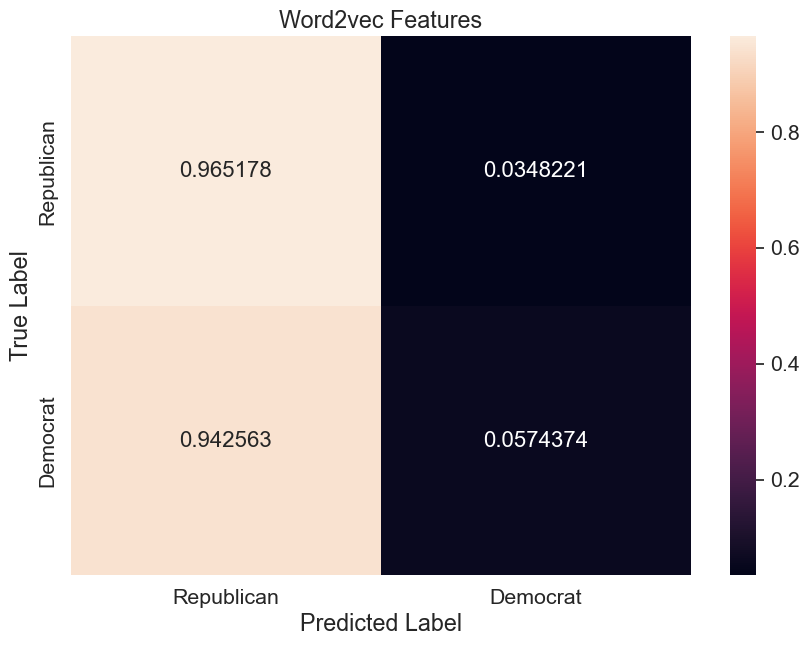

In [44]:
#Dem/Rep
for dataframe, featurization in zip(dataframes, featurization_technique):
    X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                        y_party, 
                                                        train_size = .80, 
                                                        test_size=0.20, 
                                                        random_state = 10)
    # create a model
    logit_reg = LogisticRegression()

    # fit the model
    logit_model = logit_reg.fit(X_train, y_train.ravel())

    y_pred = logit_model.predict(X_test)
    
    cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

    df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))

    df_cm = df_cm.rename(index=str, columns={0: "Republican", 1: "Democrat"})
    df_cm.index = ["Republican", "Democrat"]
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, 
               annot=True,
               annot_kws={"size": 16},
               fmt='g')

    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

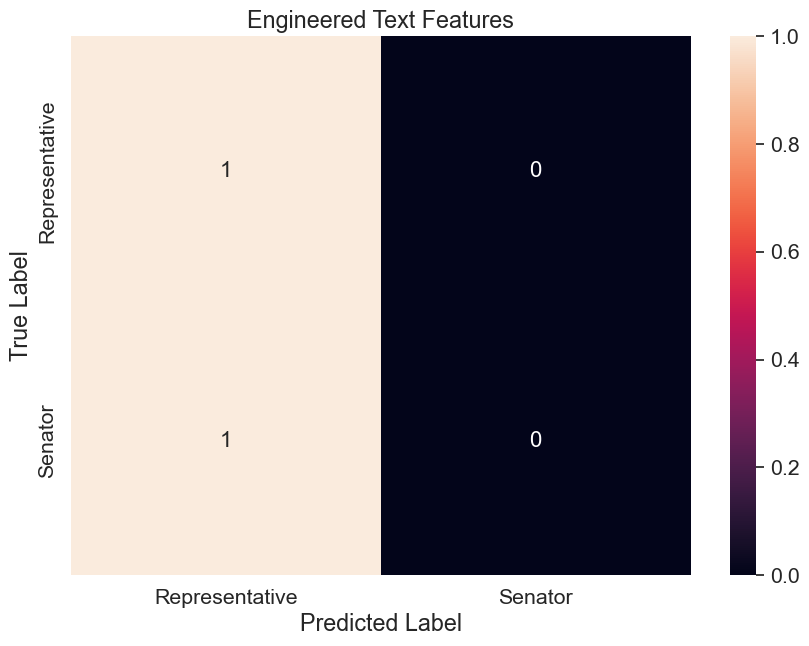

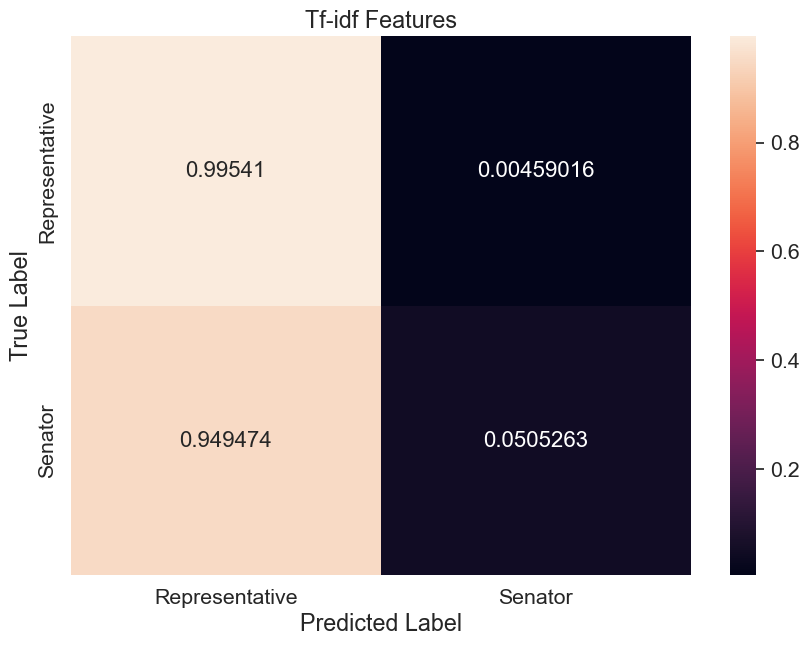

/Users/jacquelinebrown/anaconda3/envs/CSS/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


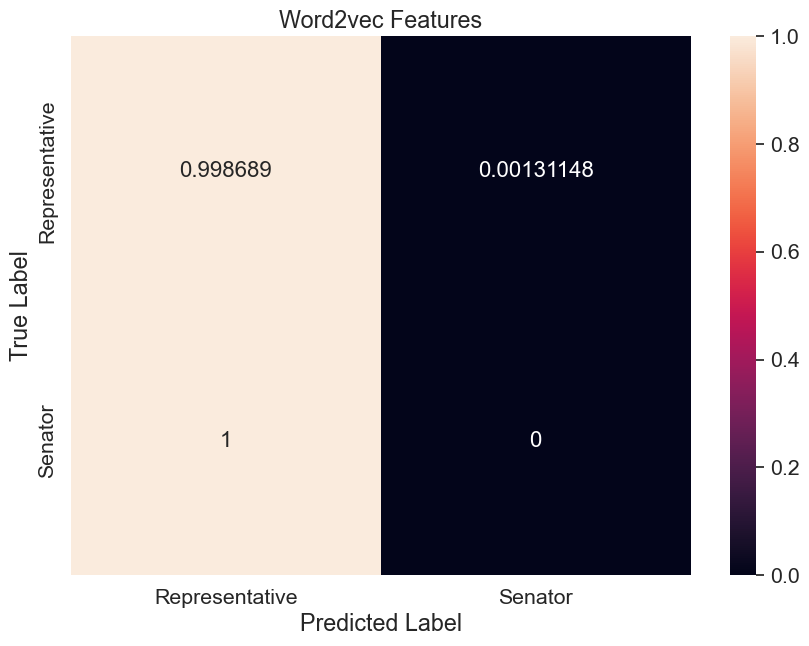

In [45]:
#Sen/Rep
for dataframe, featurization in zip(dataframes, featurization_technique):
    X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                        y_position, 
                                                        train_size = .80, 
                                                        test_size=0.20, 
                                                        random_state = 10)
    # create a model
    logit_reg = LogisticRegression()

    # fit the model
    logit_model = logit_reg.fit(X_train, y_train.ravel())

    y_pred = logit_model.predict(X_test)
    
    cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

    df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))

    df_cm = df_cm.rename(index=str, columns={0: "Representative", 1: "Senator"})
    df_cm.index = ["Representative", "Senator"]
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, 
               annot=True,
               annot_kws={"size": 16},
               fmt='g')

    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### Two Combined Models

In [ ]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])
...

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

**YOUR ANSWER HERE** ...

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

**YOUR ANSWER HERE** ...

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

**YOUR ANSWER HERE** ...

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

**YOUR ANSWER HERE** ...